## Check the results on BXD data from all methods we have...

Objectives for this analysis:
1. Check the cases in which GEMMA may have performed badly...


2. For our current Bulkscan approach, even though it is fast, but theoretically it produces non-exact solutions. Thus, we need to: 
    - Check how different the Bulkscan results are compared with scan_alt results (assuming scan_alt gives the exact results)...
    
    - For those associations that are significant based on the exact solutions, can the Bulkscan solutions also find them?
    
3. Finally, we would explore the idea that combines finding the exact VC and the LiteQTL matrix multiplication approach, by grouping the traits with same or similar $h^2$ (from null) and perform matrix multiplication for each group (taken one group of multiple trait as a matrix).
    - Can this new idea beat bulkscan both in speed and accuracy?
   

### Preparation:

In [3]:
pwd()

"/home/zyu20/git/BulkLMM.jl/test/notebooks"

In [4]:
cd("..")

In [5]:
Threads.nthreads()

24

In [6]:
include("BXDdata_for_test.jl"); ## Load BXD data used for testing:

In [76]:
using LoopVectorization
using Tables
using Test
using Plots
using ThreadTools

In [8]:
include("../src/scan_LiteQTL.jl"); ## Load multithreaded functions to be tested:

In [9]:
include("../src/parallel_helpers.jl");

In [10]:
kinship_Gc = CSV.read("run-gemma/output/kinship.cXX.txt", DataFrame, delim = '\t', header = false) |> Matrix;

### Get full results:

(for all 35k BXD traits) from GEMMA and scan_alt()

In [11]:
function get_LODs_from_alt(Y::Array{Float64, 2}, G::Array{Float64, 2}, K::Array{Float64, 2}; reml::Bool = false)

    (n, m) = size(Y);
    p = size(G, 2);
    
    intercept = reshape(ones(n, 1), :, 1);
    (Y0, X0, lambda0) = rotateData(Y, [intercept G], K);
    
    lods_from_alt = Array{Float64, 2}(undef, p, m);
    hsqs_from_alt = Array{Float64, 2}(undef, p, m);

    intercept0 = reshape(X0[:, 1], :, 1);
    
    for i in 1:m
        
        y0_i = reshape(Y0[:, i], :, 1);
        out00 = fitlmm(y0_i, intercept0, lambda0; reml = reml);
        
        lod = zeros(p);
        hsqs = zeros(p);
        X = zeros(n, 2);
        X[:, 1] = X0[:, 1];
        
        for j in 1:p
            X[:, 2] = X0[:, j+1];
            
            out11 = fitlmm(y0_i, X, lambda0; reml = reml);
            
            hsqs[j] = out11.h2;
            lod[j] = (out11.ell - out00.ell)/log(10);
            
        end
        
        lods_from_alt[:, i] = lod;
        hsqs_from_alt[:, i] = hsqs;
        
    end
    
    return (hsqs_from_alt, lods_from_alt);
    
end

get_LODs_from_alt (generic function with 1 method)

In [12]:
# @time results_from_alt = get_LODs_from_alt(pheno, geno, kinship_Gc; reml = false);

In [13]:
# writedlm("hsqs_from_alt.csv", results_from_alt[1], ',');

In [14]:
# writedlm("lods_from_alt.csv", results_from_alt[2], ',');

In [15]:
gemma = "/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64";

Read the saved output files...

In [16]:
pwd()

"/home/zyu20/git/BulkLMM.jl/test"

In [17]:
@time pvals_from_gemma = CSV.File("output/pvals_from_gemma.csv", header = false) |> Tables.matrix;

 14.755546 seconds (27.72 M allocations: 7.692 GiB, 14.30% gc time, 15.61% compilation time)


In [18]:
@time hsqs_from_gemma = CSV.File("output/hsqs_from_gemma.csv", header = false) |> Tables.matrix;

 12.990242 seconds (22.29 M allocations: 7.381 GiB, 10.19% gc time)


In [19]:
@time hsqs_from_alt = CSV.File("output/hsqs_from_alt.csv", header = false) |> Tables.matrix;

 12.026144 seconds (22.29 M allocations: 7.388 GiB, 18.52% gc time)


In [20]:
@time lods_from_alt = CSV.File("output/lods_from_alt.csv", header = false) |> Tables.matrix;

 12.692704 seconds (22.29 M allocations: 7.381 GiB, 25.64% gc time)


In [21]:
test = readdlm("run-gemma/output/gemma_results.txt.assoc.txt", '\t');

In [22]:
size(pvals_from_gemma) .== (p, m)

(true, true)

In [23]:
@testset "checkSavedResults" begin
    
    @test size(pvals_from_gemma, 1) == p && size(pvals_from_gemma, 2) == m;
    @test size(hsqs_from_gemma, 1) == p && size(hsqs_from_gemma, 2) == m;
    @test size(lods_from_alt, 1) == p && size(lods_from_alt, 2) == m;
    @test size(hsqs_from_alt, 1) == p && size(hsqs_from_alt, 2) == m;
    @test sum(hsqs_from_gemma[:, m] .== test[2:end, 9]) == p;
    @test sum(pvals_from_gemma[:, m] .== test[2:end, 10]) == p;
    
end;

Test Summary:     | Pass  Total
checkSavedResults |    6      6


### Compare results:

In [24]:
Threads.nthreads() # Number of julia threads using...

24

In [25]:
BLAS.get_num_threads() # Number of BLAS threads using...

8

In [26]:
BLAS.set_num_threads(24) # Number of BLAS threads using...

In [27]:
BLAS.get_num_threads() # Number of BLAS threads using...

24

In [28]:
grid_hsqs = collect(0:100).*0.01;

In [29]:
grid_hsqs = collect(0:10).*0.1;

In [30]:
@time lods_from_bulk = bulkscan(pheno, geno, kinship_Gc, grid_hsqs);

 16.254423 seconds (294.70 k allocations: 22.274 GiB, 17.36% gc time, 0.86% compilation time)


In [31]:
@time maxSqDiff(lods_from_bulk, lods_from_alt)

  2.016797 seconds (2 allocations: 1.939 GiB, 7.84% gc time)


7399.027333439694

In [131]:
findmax(lods_from_bulk .- lods_from_alt)

(86.01759897509169, CartesianIndex(4753, 11077))

#### Compare bulkscan and scan_alt:

In [65]:
absDiff = abs.(lods_from_bulk .- lods_from_alt);
diffArray = vec(absDiff);

In [133]:
exactDiff = vec(lods_from_bulk .- lods_from_alt);

In [66]:
quantile(diffArray)

5-element Vector{Float64}:
  8.709608555201864e-12
  0.010031305531501541
  0.049906335306336154
  0.15410116200465496
 86.01759897509169

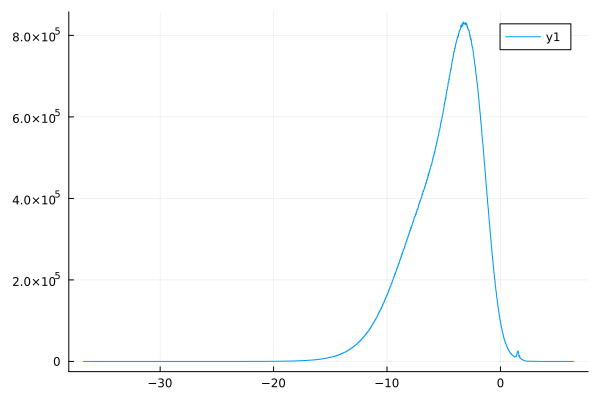

In [132]:
histogram(log2.(diffArray), binwidth = 1.0)

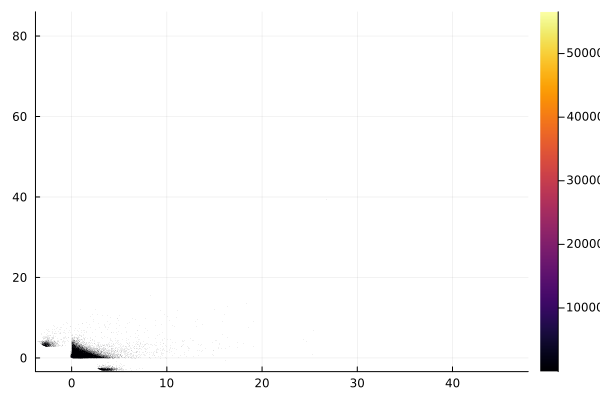

GKS: file write error (fd=54, cc=-1)
write: Bad address


In [143]:
histogram2d(vec(lods_from_alt), exactDiff)

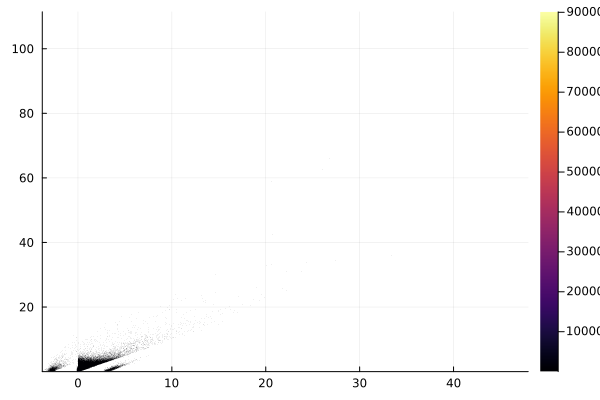

In [144]:
histogram2d(vec(lods_from_alt), vec(lods_from_bulk))

try hexbin...

Given a particular error tolerance, let's see how many the LOD scores estimated by our fast Bulkscan approach are within the acceptable error range:

In [146]:
sum(lods_from_alt .< 0)/(m*p)

0.0007208108061468519

In [149]:
histogram(vec(sum(lods_from_alt .< 0, dims = 1)))

In [152]:
vec(sum(lods_from_alt .< 0, dims = 1))

35556-element Vector{Int64}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [150]:
findall(vec(sum(lods_from_alt .< 0, dims = 1)))

386-element Vector{CartesianIndex{2}}:
 CartesianIndex(1, 33)
 CartesianIndex(1, 108)
 CartesianIndex(1, 187)
 CartesianIndex(1, 222)
 CartesianIndex(1, 227)
 CartesianIndex(1, 258)
 CartesianIndex(1, 536)
 CartesianIndex(1, 544)
 CartesianIndex(1, 703)
 CartesianIndex(1, 712)
 CartesianIndex(1, 789)
 CartesianIndex(1, 821)
 CartesianIndex(1, 929)
 ⋮
 CartesianIndex(1, 34309)
 CartesianIndex(1, 34363)
 CartesianIndex(1, 34507)
 CartesianIndex(1, 34600)
 CartesianIndex(1, 34602)
 CartesianIndex(1, 34603)
 CartesianIndex(1, 34735)
 CartesianIndex(1, 34766)
 CartesianIndex(1, 35184)
 CartesianIndex(1, 35235)
 CartesianIndex(1, 35268)
 CartesianIndex(1, 35496)

In [68]:
tol = 1.0;

In [70]:
sum(diffArray .<= tol)/length(diffArray)

0.9884312114893811

#### Compare bulkscan and gemma:

Let's first convert the GEMMA logP to LOD scores:

In [71]:
function p2lod(pval::Float64, df::Int64)
    
    lrs = invlogcdf(Chisq(df), log(1-pval))
    lod = lrs/(2*log(10))
    
    # return lrs
    return lod

end

p2lod (generic function with 1 method)

In [80]:
# @time lods_from_gemma = tmap(x -> p2lod(x, 1), pvals_from_gemma);

4946.602724 seconds (1.82 G allocations: 128.005 GiB, 66.84% gc time, 0.03% compilation time)


In [93]:
pwd()

"/home/zyu20/git/BulkLMM.jl/test"

In [94]:
# @time writedlm("output/lods_from_gemma.csv", lods_from_gemma, ',');

 83.903268 seconds (520.68 M allocations: 109.592 GiB, 16.56% gc time, 0.05% compilation time)


In [109]:
function checkNaNTraits(L::Array{Float64, 2})
    
    hasNaN = mapslices(x -> any(isnan.(x)), L, dims = 1);
    return hasNaN;
    
end

checkNaNTraits (generic function with 1 method)

In [116]:
hasNaN = checkNaNTraits(lods_from_gemma)

1×35556 Matrix{Bool}:
 0  1  0  0  0  0  0  0  0  0  0  0  0  …  1  0  0  0  0  0  0  0  0  0  0  0

In [117]:
m - sum(hasNaN)

31923

In [92]:
sum(isnan.(lods_from_bulk))

0

In [119]:
sub_L_gemma = lods_from_gemma[:, .!vec(test)]

7321×31923 Matrix{Float64}:
 0.000120008  0.00296458  0.0161317   …  0.0472253   0.177029     0.348691
 0.000120008  0.00296458  0.0161317      0.0472253   0.177029     0.348691
 0.000120008  0.00296458  0.0161317      0.0472253   0.177029     0.348691
 0.000120008  0.00296458  0.0161317      0.0472253   0.177029     0.348691
 0.000120008  0.00296458  0.0161317      0.0472253   0.177029     0.348691
 0.000120008  0.00296458  0.0161317   …  0.0472253   0.177029     0.348691
 0.000120008  0.00296458  0.0161317      0.0472253   0.177029     0.348691
 0.000120008  0.00296458  0.0161317      0.0472253   0.177029     0.348691
 0.000120008  0.00296458  0.0161317      0.0472253   0.177029     0.348691
 0.000120008  0.00296458  0.0161317      0.0472253   0.177029     0.348691
 0.000120008  0.00296458  0.0161317   …  0.0472253   0.177029     0.348691
 0.000119929  0.00296488  0.0161312      0.0472258   0.177038     0.348693
 0.00953411   0.017988    0.00472361     0.0558368   0.359087     0.3863

In [120]:
sub_L_bulk = lods_from_bulk[:, .!vec(test)];

In [127]:
any(isnan.(sub_L_gemma))

false

In [128]:
any(isnan.(absDiff_withGemma))

false

In [129]:
absDiff_withGemma = abs.(sub_L_bulk .- sub_L_gemma);
diffArray_withGemma = vec(absDiff_withGemma);

In [130]:
quantile(diffArray_withGemma)

5-element Vector{Float64}:
   1.245813953301006e-10
   0.009011057827680191
   0.04779152951479171
   0.1527810090113279
 NaN

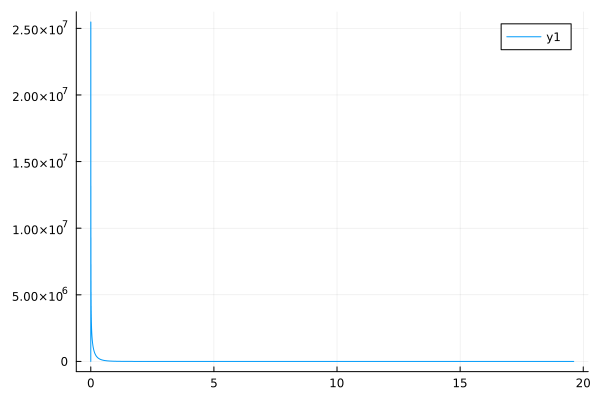

In [126]:
histogram(diffArray_withGemma, binwidth = 1.0)

In [124]:
sum(diffArray_withGemma .<= tol)/length(diffArray_withGemma)

0.9888348629902861

## Explore the binning idea:

### Compute null hsqs for every trait:

In [10]:
BLAS.set_num_threads(1)

In [11]:
function get_hsqs_from_null(Y::Array{Float64, 2}, K::Array{Float64, 2}; reml::Bool = true)

    (n, m) = size(Y);
    intercept = reshape(ones(n, 1), :, 1);
    (Y0, intercept0, lambda0) = rotateData(Y, intercept, K);
    
    hsqs_from_null = Array{Float64, 1}(undef, m);
    
    for i in 1:m
        
        y0_i = reshape(Y0[:, i], :, 1);
        out00 = fitlmm(y0_i, intercept0, lambda0; reml = reml);
        hsqs_from_null[i] = out00.h2;
        
    end
    
    return hsqs_from_null;
    
end

get_hsqs_from_null (generic function with 1 method)

In [16]:
@time hsqs_from_null = get_hsqs_from_null(pheno, kinship_Gc; reml = true);

 12.457308 seconds (31.89 M allocations: 12.694 GiB, 14.39% gc time)


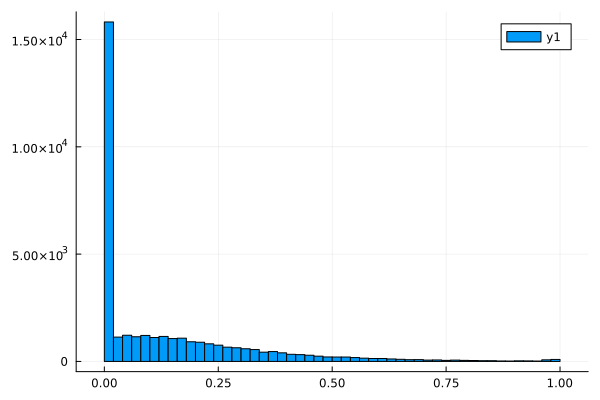

In [20]:
histogram(hsqs_from_null)

In [21]:
findall(hsqs_from_null .> 0.90)

239-element Vector{Int64}:
   536
   712
  1292
  1558
  1634
  2571
  2886
  3069
  3268
  3403
  3446
  3745
  3950
     ⋮
 32890
 32955
 33026
 33160
 33310
 33458
 34153
 34344
 34507
 34735
 34766
 35268

In [19]:
hsqs_from_null[7919]

0.8182834272313365

In [ ]:
function groupTraits(m::Int64, listHsq::Array{Float64, 1}, quantileHsq::Array{Float64, 2})
    
    
    
    
end